# NetworkX - Partitions

_The contents of this notebook have been derived from "A First Course in Network Science" by Filippo Menczer. [You can see their official Github repository here.](https://github.com/CambridgeUniversityPress/FirstCourseNetworkScience/tree/master)_

Contents:

1. [Partitions](#1.-Partitions)
2. [Modularity](#2.-Modularity)
3. [Zachary's Karate Club](#3.-Zachary's-Karate-Club)
4. [Girvan-Newman clustering](#4.-Girvan-Newman-clustering)


In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import random

## 1. Partitions

A **partition** of a graph is a separation of its nodes into disjoint groups. Consider the following graph:


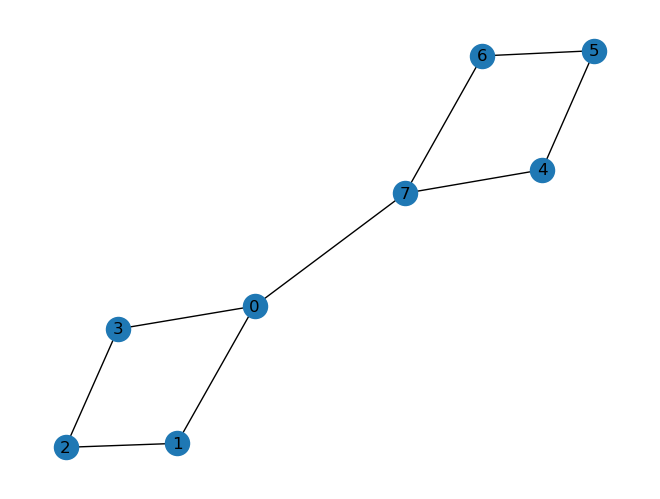

In [3]:
G = nx.Graph()
nx.add_cycle(G, [0, 1, 2, 3])
nx.add_cycle(G, [4, 5, 6, 7])
G.add_edge(0, 7)

nx.draw(G, with_labels=True)
plt.show()

The following is an example of a partition of these nodes:


In [4]:
partition = [
    {1, 2, 3},
    {4, 5, 6},
    {0, 7},
]

Observe that every node in the graph is in exactly one of the sets in the partition. Formally, a partition is a list of sets such that every node is in exactly one set. NetworkX can verify that our partition is valid:


In [5]:
nx.community.is_partition(G, partition)

True

When developing community detection algorithms, we often make use of a _partition map_, which is a dictionary mapping node names to a partition index. This is useful for quickly comparing if two nodes are in the same cluster in the partition:


In [6]:
partition_map = {}
for idx, cluster_nodes in enumerate(partition):
    for node in cluster_nodes:
        partition_map[node] = idx

partition_map

{1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 0: 2, 7: 2}

In this dictionary, the keys are the node names and two nodes will have the same value if they are in the same partition:


In [7]:
partition_map[0] == partition_map[7]

True

We can visualize our partition by drawing the graph with nodes colored by their partition membership:


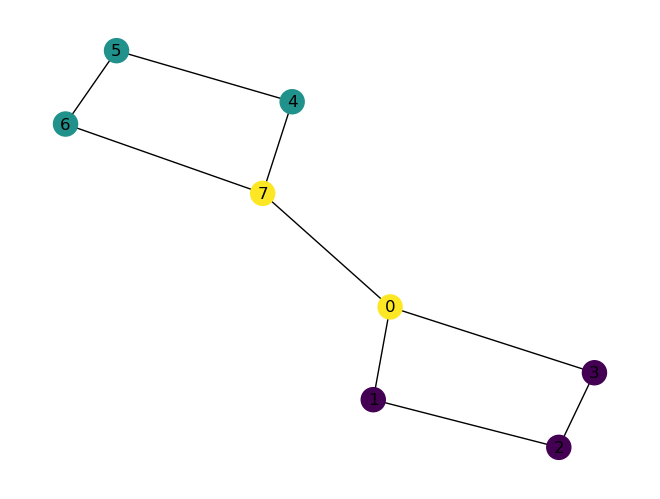

In [8]:
node_colors = [partition_map[n] for n in G.nodes]

nx.draw(G, node_color=node_colors, with_labels=True)

There are two trivial partitions:

1. The partition with one set containing every node;
2. The partition with N sets, each containing a single node.

A valid partition thus contains between 1 and N sets.

Feel free to experiment by changing the partition above and running the subsequent cells.


---


## 2. Modularity


At a high level, network community detection consists of finding a partition that achieves good separation between the groups of nodes. Before we get into how to find good partitions of a graph, we need an objective -- a way to measure how good the partition is. Modularity is one such objective function.

The modularity of a graph partition compares the number of intra-group edges with a random baseline. Higher modularity scores correspond to a higher proportion of intra-group edges, therefore fewer inter-group edges and better separation of groups.

For weighted undirected networks, as described in the text, we have

$$
Q_w=\frac{1}{W}\sum_C \left(W_C-\frac{s_C^2}{4W}\right),
$$

where

- $W$ is the total weight of the links of the network,
- $W_C$ the total weight of the internal links of cluster $C$, and
- $s_C$ the total strength of the nodes of $C$.

The total weight $W$ is half the total strength for the same reason that the number of edges $L$ is half the total degree. While this formula may look a bit complicated, it's straightforward to write code to compute the sum:


In [9]:
nx.community.quality.modularity(G, partition)

0.2222222222222222

Let's compare this to a partition we would suspect to have higher modularity:


In [10]:
partition_2 = [
    {0, 1, 2, 3},
    {4, 5, 6, 7},
]
nx.community.quality.modularity(G, partition_2)

0.38888888888888884

---


## 3. Zachary's Karate Club


When writing and testing community-detection algorithms, it helps to make use of benchmark networks: graphs with a known, "natural" community structure. Perhaps the most famous benchmark graph is Zachary's Karate Club. It contains 34 nodes, representing members of a karate club whose interactions were monitored over a period of three years by researchers. Links in this graph connect individuals interacting outside club activities, a proxy for social ties.

During the course of the study, a conflict between the instructor Mr. Hi (node 0) and the president, or Officer (node 33) led to a split of the club into separate groups led by Mr. Hi and Officer. In this case we know whom each member of the group followed after the split, providing empirical community labels: those members who followed Mr. Hi are said to be one community and those following the Officer make up the other.

For this graph, we assume that the post-split group composition was largely driven by the social ties: members of the same friend groups would want to be part of the same club after the split. We thus expect a good community-detection algorithm to predict the post-split group composition with high accuracy.

Zachary's karate club is such a popular benchmark graph that it has its own function in NetworkX:


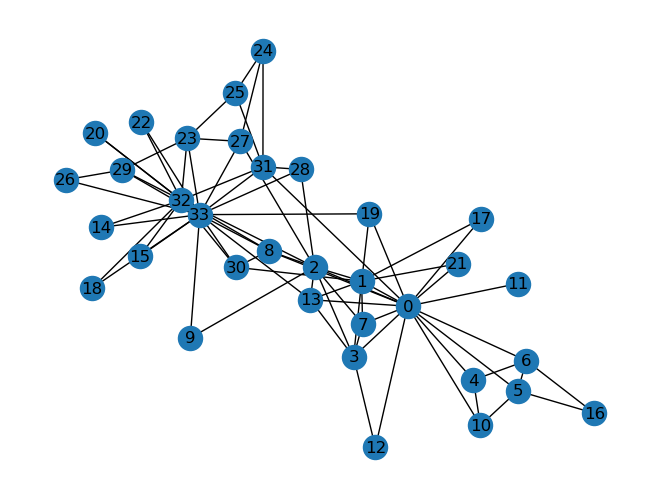

In [11]:
K = nx.karate_club_graph()
nx.draw(K, with_labels=True)

Each node in a NetworkX graph has a dictionary of _attributes_ associated with it. This dictionary can hold arbitrary data about a node. We can get the attributes for a single node by giving the node name to the `nodes` object.

Each node in this graph has a `'club'` attribute, indicating whether the member followed the instructor or the president after the split:


In [12]:
K.nodes[0]

{'club': 'Mr. Hi'}

In [13]:
K.nodes[9]

{'club': 'Officer'}

We can visualize these labels by coloring each node according to its `'club'` attribute:


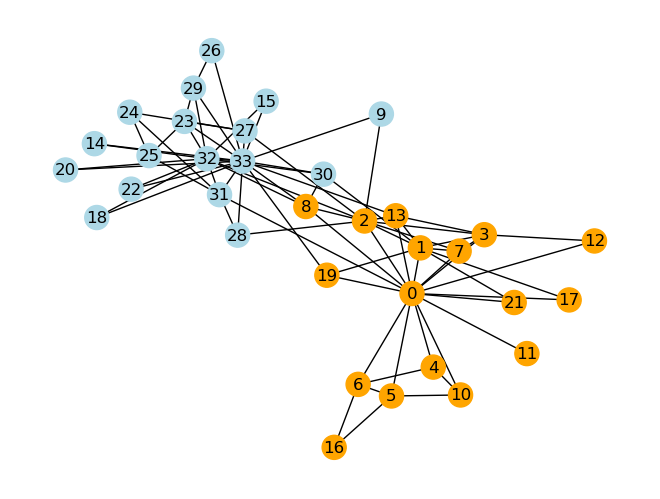

In [14]:
K = nx.karate_club_graph()
club_color = {
    "Mr. Hi": "orange",
    "Officer": "lightblue",
}
node_colors = [club_color[K.nodes[n]["club"]] for n in K.nodes]
nx.draw(K, node_color=node_colors, with_labels=True)

This separation looks good, in that there are relatively few inter-community links as opposed to intra-community links. Let's create a graph partition based on these labels and measure its modularity.

We can do this by creating a dictionary of two sets, one for each value of the nodes' `'club'` attribute, then assigning the nodes to the corresponding set.


In [15]:
groups = {
    "Mr. Hi": set(),
    "Officer": set(),
}

for n in K.nodes:
    club = K.nodes[n]["club"]
    groups[club].add(n)

groups

{'Mr. Hi': {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21},
 'Officer': {9,
  14,
  15,
  18,
  20,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33}}

By using the dictionary's `.values()` method, we can get a list of sets that define our partition:


In [16]:
empirical_partition = list(groups.values())
empirical_partition

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21},
 {9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]

In [17]:
nx.community.is_partition(K, empirical_partition)

True

Since our partition is indeed a valid partition, we can get the modularity of this partition:


In [18]:
nx.community.quality.modularity(K, empirical_partition)

0.39143756676224206

This is a relatively high modularity, which is what we expect.


### Comparison to a random partition

For the sake of comparison, let's generate a random partition of this network and check its modularity. We would expect a modularity close to zero in this case.

First we generate a sample of 17 nodes, half the total number of nodes, and assign them to one community. Our second community then includes the nodes in the graph not in the first community. We can use some set arithmetic to do this concisely:


In [19]:
random_nodes = random.sample(sorted(K.nodes), 17)
random_partition = [set(random_nodes), set(K.nodes) - set(random_nodes)]
random_partition

[{6, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 22, 25, 28, 29, 32},
 {0, 1, 2, 3, 4, 5, 7, 16, 17, 21, 23, 24, 26, 27, 30, 31, 33}]

We can visualize this partition and observe that the communities are much less natural-looking, as we would expect from a random assignment.


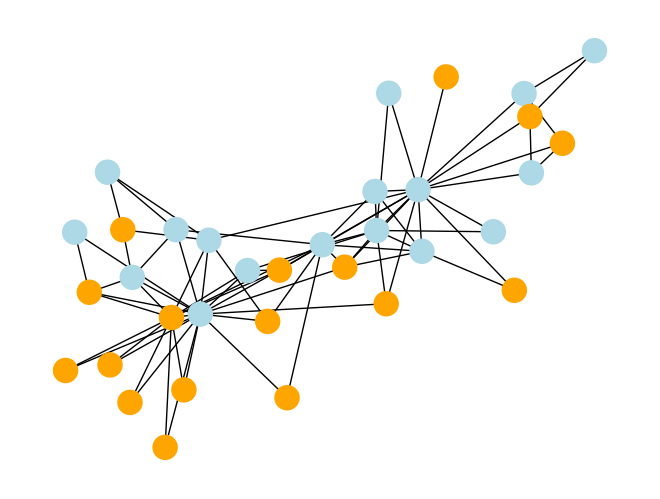

In [20]:
random_node_colors = ["orange" if n in random_nodes else "lightblue" for n in K.nodes]
nx.draw(K, node_color=random_node_colors)

And finally we can test the modularity of this partition:


In [21]:
nx.community.quality.modularity(K, random_partition)

-0.09059987631416207

Since this is a random process the modularity won't be exactly zero, but it should be fairly close. Go ahead and repeat the process of generating a random partition and testing its modularity -- it will fluctuate around its mean value of zero.


---


## 4. Girvan-Newman clustering


Recall from the text the Girvan-Newman clustering algorithm:

1. Create a partition sequence
1. Calculate the betweenness centrality for all links.
1. Remove the link with largest betweenness and create a partition using connected components.
1. Recalculate the betweenness centrality of the links of the resulting graph.
1. Repeat from step B until no links remain.
1. Evaluate each partition in the sequence and choose the one with the highest modularity.

During this process, the number of connected components in the graph will increase monotonically as clusters are broken up. Since we are removing one link at a time, the number of connected components can increase by at most one between steps in the sequence -- it's not possible for a single edge to connect more than two nodes, and thus components.

We hope that the resulting partition of the graph will approximate its underlying community structure. We'll use the Karate Club graph here because we know the ground-truth community labels and can compare the result obtained from the algorithm.

`nx.community.girvan_newman(G)` will generate a sequence containing one partition of each size greater than one. Here we can see the first several are the same as those we generated:


In [48]:
list(nx.community.girvan_newman(G))[:5]

[({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
  {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}),
 ({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
  {2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33},
  {9}),
 ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21},
  {2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33},
  {4, 5, 6, 10, 16},
  {9}),
 ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21},
  {2, 24, 25, 27, 28, 31},
  {4, 5, 6, 10, 16},
  {8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33},
  {9}),
 ({0, 1, 3, 7, 12, 13, 17, 19, 21},
  {2, 24, 25, 27, 28, 31},
  {4, 5, 6, 10, 16},
  {8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33},
  {9},
  {11})]

The two cluster partition is:


In [57]:
two_cluster_partition = next(nx.community.girvan_newman(G))

two_cluster_partition

({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21},
 {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33})

How good is this partition? We can get its modularity:


In [58]:
nx.community.quality.modularity(G, two_cluster_partition)

0.3476602762317048

Pretty good -- comparable to the ground truth community labels. Let's compare these side-by-side:


Text(0.5, 1.0, 'Actual communities')

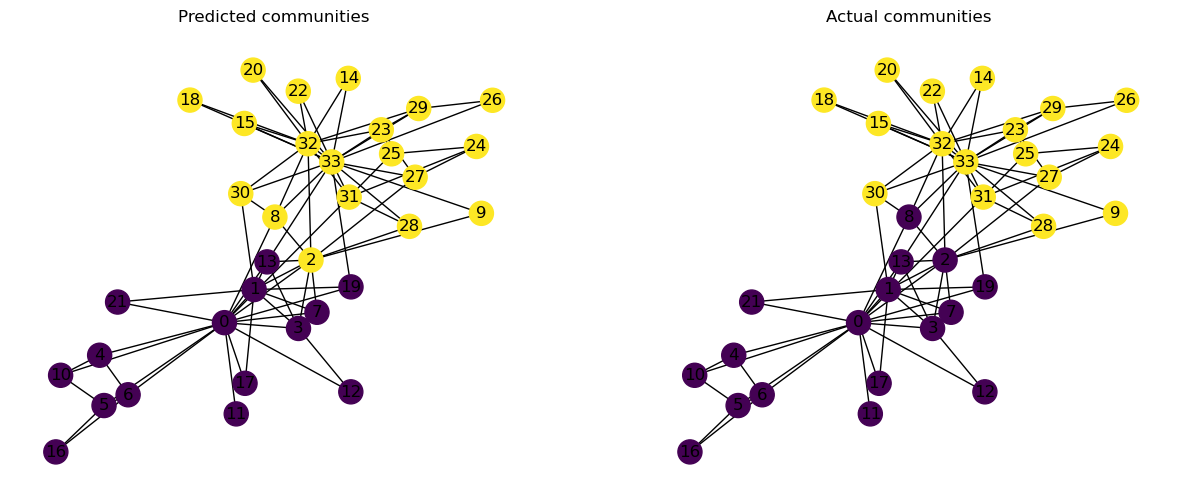

In [54]:
pos = nx.layout.spring_layout(G)
fig = plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
two_cluster_partition = next(nx.community.girvan_newman(G))
node_colors = [0 if n in two_cluster_partition[0] else 1 for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors, pos=pos)
plt.title("Predicted communities")

plt.subplot(1, 2, 2)
node_colors = [G.nodes[n]["club"] == "Officer" for n in G.nodes()]
nx.draw(G, with_labels=True, node_color=node_colors, pos=pos)
plt.title("Actual communities")

We can see that the predicted community labels are pretty accurate, only differing on a couple nodes that, visually, seem like they could plausibly beling to either group. Zachary's original paper even explains the practical considerations of one of these mispredicted nodes: student 8 was very near receiving his black belt from Mr. Hi and thus did not want to leave the group even though several of his friends did.


In [55]:
G.nodes[8]

{'club': 'Mr. Hi'}

---
